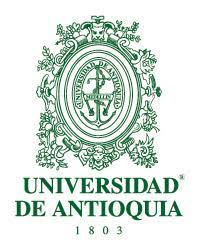


<h1> Modulation Recognition using Deep Learning models <h1>

**Tratamiento de Señales III**

**Integrantes**

- Carolina Jiménez Restrepo

- Mariana Noreña Vásquez

## Librerías

In [1]:
import os,random
import numpy as np
import pickle, sys
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras.models as models

from tensorflow import keras
from keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Reshape,Dense,Dropout,Activation,Flatten
from tensorflow.keras.layers import GaussianNoise
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D
from tensorflow.keras.regularizers import *


%matplotlib inline

## Conjunto de datos



In [2]:
# Se descarga el conjunto de datos
!gdown '1Yuj_rq3EEITslOQ0AHEl2HKzDovMQH3K'

Downloading...
From: https://drive.google.com/uc?id=1Yuj_rq3EEITslOQ0AHEl2HKzDovMQH3K
To: /content/RML2016.10a_dict.pkl
100% 641M/641M [00:09<00:00, 69.7MB/s]


In [3]:
# Se almacenan los datos en una variable
with open("RML2016.10a_dict.pkl", 'rb') as f:
    Xd = pickle.load(f, encoding="latin1")

In [4]:
# Se identifica cuántas modulaciones y relaciones SNR hay en el dataset
snrs,mods = map(lambda j: sorted(list(set(map(lambda x: x[j], Xd.keys())))), [1,0])

In [5]:
print('Total de modulaciones: ', len(mods))
print('Tipos de modulaciones en el dataset: {}'.format(mods))
print('Total de SNRs', len(snrs))
print('Valores SNRS presentes en el dataset: {}'.format(snrs))

Total de modulaciones:  11
Tipos de modulaciones en el dataset: ['8PSK', 'AM-DSB', 'AM-SSB', 'BPSK', 'CPFSK', 'GFSK', 'PAM4', 'QAM16', 'QAM64', 'QPSK', 'WBFM']
Total de SNRs 20
Valores SNRS presentes en el dataset: [-20, -18, -16, -14, -12, -10, -8, -6, -4, -2, 0, 2, 4, 6, 8, 10, 12, 14, 16, 18]


**<h3>Análisis del dataset<h3>**

El dataset GNU Radio en su distribución presenta la siguiente estructura: 1000 muestras y, 128 datos de fase y cuadratura para cada una de las once modulaciones y las veinte relaciones señales a ruido que se analizaron. Adicionalmente, la segunda dimensión tiene un valor de 2 ya que hace alusión a las componentes I-Q.

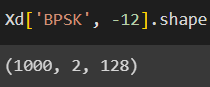

En la imagen se puede visualizar una de las tantas conjugaciones entre modulaciones y SNRs existentes en el dataset. **BPSK** representa a una de las modulaciones y -12 representa la SNR en unidades de decibeles (dB). También se puede apreciar la forma en la que está distribuida la información previamente descrita

In [6]:
def reconstructSignal(s):
    I = s[0,:]   # I component
    Q = s[1,:]   # Q component
    n = len(I)   # number of samples
    f = 1e6     # Carrier frequency
    return I*np.cos(2*np.pi*f*np.arange(n)) + Q*np.sin(2*np.pi*f*np.arange(n))

A continuación, se muestra cómo cambia una misma modulación al ser afectada por varias SNRs.

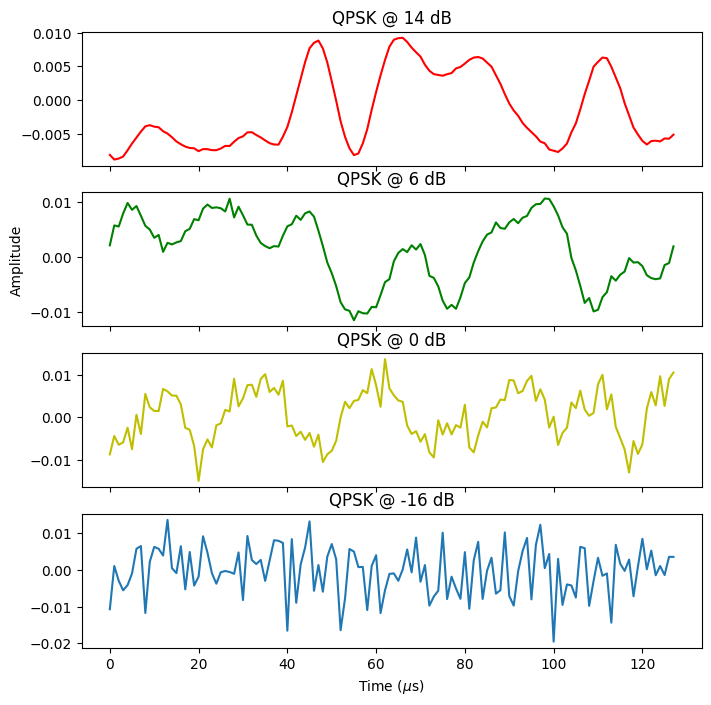

In [7]:
# Plot some of the data
nFigs = 4

plt.figure(figsize=(8, 8))

ax1 = plt.subplot(nFigs, 1, 1);
plt.plot(reconstructSignal(Xd['QPSK', 14][2,:,:]), color='r');
plt.title('QPSK @ 14 dB')

ax2 = plt.subplot(nFigs, 1, 2, sharex=ax1);
plt.plot(reconstructSignal(Xd['QPSK', 6][99,:,:]), color='g');
plt.title('QPSK @ 6 dB')

plt.ylabel('Amplitude');

ax3 = plt.subplot(nFigs, 1, 3, sharex=ax1)
plt.plot(reconstructSignal(Xd['QPSK', 0][456,:,:]), color='y');
plt.title('QPSK @ 0 dB')

ax4 = plt.subplot(nFigs, 1, 4, sharex=ax1)
plt.plot(reconstructSignal(Xd['QPSK', -16][32,:,:]));
plt.title('QPSK @ -16 dB')

# We only need to show the xticks on the bottom subplot
plt.setp(ax3.get_xticklabels(), visible=False)
plt.setp(ax2.get_xticklabels(), visible=False)
plt.setp(ax1.get_xticklabels(), visible=False)

plt.xlabel(r'Time ($\mu$s)');

Seguidamente, para tener un mejor manejo de la información, se procede a formar una matriz con el dataset. Se debe tener en cuenta la distribución de la información mencionada con anterioridad ya que de eso depende comprender la estructura que tendrá la matriz.

Recordar que, se tienen once modulaciones en donde cada una cuenta con mil muestras para cada SNR (veinte SNRs). De esta manera, las dimensiones de la matriz son: $11*1000*20=220000$.

Posteriormente, se agrega una clase con veinte mil muestras de ruido AWG en caso tal que no pueda clasificar bien los datos. Esto se hace con el objetivo de evitar que el sistema caiga en un error mayor al clasificar la modulación debido al ruido que tiene. Lo anterior, induce a una dimensionalidad total de (240000,2,128)

In [8]:
# Todos los datos que componen el dataset pasan a formar una matrix
snrs,mods = map(lambda j: sorted(list(set(map(lambda x: x[j], Xd.keys())))), [1,0])
X = []
lbl = []
for mod in mods:
    for snr in snrs:
        X.append(Xd[(mod,snr)])
        for i in range(Xd[(mod,snr)].shape[0]):  lbl.append((mod,snr))
X = np.vstack(X)
X.shape

(220000, 2, 128)

In [9]:
# Se agrega ruido al dataset matricial, para que la clasificación tenga que elegir en caso de que no pueda clasificar bien los datos

numNoiseSamples = 20000 # Add 20,000 samples of just Gaussian noise
for i in range(numNoiseSamples):
    lbl.append(['Noise', snrs[i%len(snrs)]])

mods.append('Noise')
X_noise = np.random.normal(0, 0.01, [numNoiseSamples, 2, 128])
X = np.concatenate((X, X_noise))  # Add noise to the end of the data

En cuanto a los labels del problema, estos se deben de convertir a One-Hot encoded ya que un computador solo entiende 1's y 0's. Esta conversión da un array de doce elementos los cuales corresponden a las once modulación y a la clase de ruido agregada al final de la matriz.

In [10]:
# Se convierte a un array de binarios
lbl = np.array(lbl) # Convert from list to numpy array (for speed)

y_encoded = LabelBinarizer().fit_transform(lbl[:,0])

print(y_encoded.shape)

(240000, 12)


In [11]:
y_encoded[:5]

array([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

## Train Test Split

In [12]:
np.random.seed(2016)
n_examples = X.shape[0]
n_train = int(n_examples * 0.7)

# Now get a list of random indicies to sample for the training set
train_idx = np.random.choice(range(0,n_examples), size=n_train, replace=False)

# Testing set is whatever indicies are left over
test_idx = list(set(range(0,n_examples))-set(train_idx))

# Now split up the data by the random indicies
X_train = X[train_idx]
X_test =  X[test_idx]
Y_train = y_encoded[train_idx]
Y_test = y_encoded[test_idx]

(X_train, X_valid) = X_train[8000:], X_train[:8000]
(Y_train, Y_valid) = Y_train[8000:], Y_train[:8000]

print('Training set: {}'.format(np.shape(X_train)))
print('Validation set: {}'.format(np.shape(X_valid)))
print('Test set: {}'.format(np.shape(X_test)))

Training set: (160000, 2, 128)
Validation set: (8000, 2, 128)
Test set: (72000, 2, 128)


In [13]:
# Se tienen 12 clases, 11 modulación más el ruido que se agregó
in_shp = list(X_train.shape[1:])   # This is the input shape of 2 channels x 128 time samples
print(X_train.shape, in_shp)
classes = mods
print(classes)

(160000, 2, 128) [2, 128]
['8PSK', 'AM-DSB', 'AM-SSB', 'BPSK', 'CPFSK', 'GFSK', 'PAM4', 'QAM16', 'QAM64', 'QPSK', 'WBFM', 'Noise']


In [14]:
# Reshape de train, valid y test (-,2,128,1)
w, h = 2, 128
X_train = X_train.reshape(X_train.shape[0], w, h, 1)
X_valid = X_valid.reshape(X_valid.shape[0], w, h, 1)
X_test = X_test.reshape(X_test.shape[0], w, h, 1)

## NN Model

In [15]:
dr = 0.6 # dropout rate (%) = percentage of neurons to randomly lose each iteration
classes = 12
model = models.Sequential()

#Reshape
model.add(Reshape((w,h,1), input_shape=(w,h)))

# Must define the input shape in the first layer of the neural network
model.add(Convolution2D(filters=16, kernel_size=(1,8), padding='same', strides=(1,2), activation='relu', input_shape=(w,h,1)))

model.add(Convolution2D(filters=32, kernel_size=(1,8), padding='same', strides=(1,2), activation='relu'))

model.add(Convolution2D(filters=64, kernel_size=(1,8), padding='same', strides=(1,2), activation='relu'))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(dr))
model.add(Dense(256, activation='relu'))
model.add(Dropout(dr))
model.add(Dense(classes, activation='softmax'))

# Take a look at the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 2, 128, 1)         0         
                                                                 
 conv2d (Conv2D)             (None, 2, 64, 16)         144       
                                                                 
 conv2d_1 (Conv2D)           (None, 2, 32, 32)         4128      
                                                                 
 conv2d_2 (Conv2D)           (None, 2, 16, 64)         16448     
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dropout (Dropout)           (None, 512)               0

- Dropout permite apagar aleatoriamente neuronas en cada capa
- Earlystopping, detiene el entrenamiento
- Flatten convierte lo que recibe en un super vector.

In [16]:
# Se compila el modelo creado

model.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

## Entrenamiento del modelo

In [17]:
# Set up some params
nb_epoch = 150     # number of epochs to train on
batch_size = 1024  # training batch size

In [18]:
# perform training ...
#   - call the main training loop in keras for our network+dataset
filepath = './'
modelWeightsFile = filepath + 'PESOS_TSIII.wts.h5'  # Save the model weights to this file

history = model.fit(X_train,
    Y_train,
    batch_size=batch_size,
    epochs=nb_epoch,
    verbose=2,
    validation_data=(X_valid, Y_valid),
    callbacks = [
        keras.callbacks.ModelCheckpoint(modelWeightsFile, monitor='val_loss', verbose=1, save_best_only=True, mode='auto'),
        keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='auto')
    ])

# we re-load the best weights once training is finished
model.load_weights(modelWeightsFile)

Epoch 1/150

Epoch 1: val_loss improved from inf to 1.67288, saving model to ./PESOS_TSIII.wts.h5
157/157 - 7s - loss: 2.2018 - accuracy: 0.1946 - val_loss: 1.6729 - val_accuracy: 0.3842 - 7s/epoch - 48ms/step
Epoch 2/150


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 2: val_loss improved from 1.67288 to 1.44894, saving model to ./PESOS_TSIII.wts.h5
157/157 - 1s - loss: 1.5925 - accuracy: 0.3935 - val_loss: 1.4489 - val_accuracy: 0.4446 - 1s/epoch - 8ms/step
Epoch 3/150

Epoch 3: val_loss improved from 1.44894 to 1.37923, saving model to ./PESOS_TSIII.wts.h5
157/157 - 1s - loss: 1.4952 - accuracy: 0.4286 - val_loss: 1.3792 - val_accuracy: 0.4678 - 1s/epoch - 8ms/step
Epoch 4/150

Epoch 4: val_loss improved from 1.37923 to 1.31648, saving model to ./PESOS_TSIII.wts.h5
157/157 - 1s - loss: 1.4131 - accuracy: 0.4635 - val_loss: 1.3165 - val_accuracy: 0.5014 - 1s/epoch - 8ms/step
Epoch 5/150

Epoch 5: val_loss improved from 1.31648 to 1.26853, saving model to ./PESOS_TSIII.wts.h5
157/157 - 1s - loss: 1.3636 - accuracy: 0.4855 - val_loss: 1.2685 - val_accuracy: 0.5173 - 1s/epoch - 8ms/step
Epoch 6/150

Epoch 6: val_loss improved from 1.26853 to 1.25623, saving model to ./PESOS_TSIII.wts.h5
157/157 - 1s - loss: 1.3207 - accuracy: 0.5016 - val_loss:

- A medida que se aumenta el tamaño del kernel $((1,2), (1,4), ....)$ con un *strides* igual a $(1,2)$, mejora la precisión del modelo. Para un kernel igual a $(1,2)$ se obtiene 0.5625, para $(1,4)$ se obtiene 0.58, para $(1,8)$ es 0.5884, para $(1,16)$ se llega a 0.5873, entre otros.

- Ahora, al analizar el accuracy cuando se cambia el *strides* dejando el tamaño del kernel en un valor fijo, se determina que la precisión del modelo disminuye a comparación del procedimiento descrito anteriormente. Por ejemplo, con un kernel (1,8) y un *strides* de $(1,4)$, el accuracy obtenido es 0.5795. Al variar el *strides* a $(1,8)$, la precisión obtenida es 0.5349. Adicionalmente, al incrementar el *strides*, se encuentra que tarda más épocas en encontrar el punto óptimo a través del *Early stopping*


## Evaluación del modelo

In [19]:
y_predict = model.predict(X_test, batch_size=batch_size)
print(classification_report(np.argmax(Y_test, axis=1), np.argmax(y_predict, axis=1)))

71/71 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

           0       0.54      0.51      0.52      5957
           1       0.53      0.72      0.61      5852
           2       0.27      0.90      0.42      5932
           3       0.83      0.59      0.69      6051
           4       0.72      0.62      0.67      5963
           5       0.80      0.66      0.72      6022
           6       1.00      1.00      1.00      6125
           7       0.89      0.66      0.75      5991
           8       0.44      0.36      0.39      5906
           9       0.58      0.42      0.49      6029
          10       0.80      0.36      0.49      6072
          11       0.82      0.24      0.37      6100

    accuracy                           0.59     72000
   macro avg       0.68      0.59      0.59     72000
weighted avg       0.69      0.59      0.59     72000



De los parámetros mostrados anteriormente se extraer que:

- La precisión indica que tan bien discrimina el modelo entre las clases
- El recall o sensitivity representa la capacidad del modelo para detectar patrones de las clases.
- El F1-score se puede ver como un punto intermedio entre la precisión y el recall ya que es la media ponderada de las dos métricas. Se pueden tomar valores entre 0 y 1.

Se observa que, las tres métricas cambian para cada clase analizada. La precisión se comporta bien para todas las clases, pero en la clase 2 presenta un comportamiento no deseado ya que su valor es muy bajo. Respecto al recall, las clases 8, 10 y 11 tienen un valor muy bajo indicando que el modelo no tienen tanta capacidad para detectar señales o patrones de esas clases. Finalmente, respecto al F1-score, se tiene que su valor es muy pequeño para las clases 8 y 11 dado a que es un promedio entre las dos primeras variables analizadas.



## Curva de pérdidas

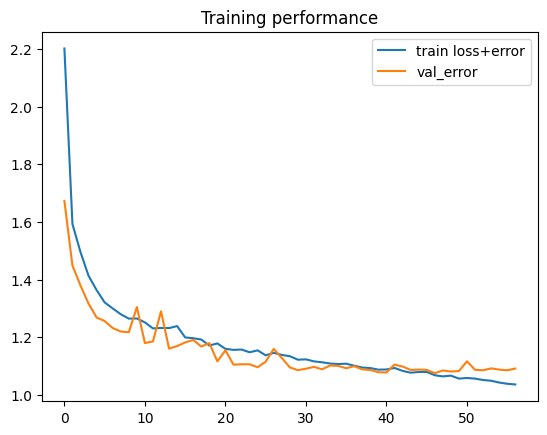

In [20]:
# Show loss curves
plt.figure();
plt.title('Training performance');
plt.plot(history.epoch, history.history['loss'], label='train loss+error');
plt.plot(history.epoch, history.history['val_loss'], label='val_error');
plt.legend();

Una manera de visualizar el comportamiento del modelo es mediante la curva de pérdidas del conjunto de train y validación. Se observa que el error de validación sigue la tendencia del error de entrenamiento, sin embargo, se mantiene por debajo de este último. Exceptuando un cambio abrupto en la validación al comienzo de la gráfica, esto se debe a que, al analizar con detenimiento las épocas, se encuentra que en un principio la pérdida en la validación es mayor a la de entrenamiento y esto va mejorando a medida que el modelo aprende más información de los datos suministrados.

## Confusion Matrix

In [21]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues, labels=[]):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

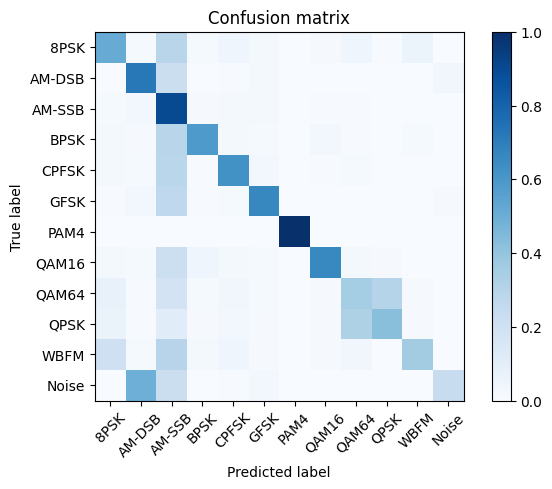

In [22]:
# Plot confusion matrix
classes = mods
conf = np.zeros([len(classes),len(classes)])
confnorm = np.zeros([len(classes),len(classes)])
for i in range(0,X_test.shape[0]):
    j = list(Y_test[i,:]).index(1)
    k = int(np.argmax(y_predict[i,:]))
    conf[j,k] = conf[j,k] + 1
for i in range(0,len(classes)):
    confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
plot_confusion_matrix(confnorm, labels=classes)

Otra forma de comprender la predicción de los datos, es a través de la matriz de confusión, la cual da un acercamiento entre las etiquetas reales y las estimadas.

Se puede observar que, las modulaciones que mejor se estimaron corresponden a AM-SSB, AM-DSB, GFSK, CPFSK, PAM4, QAM16 y QPSK.

112/112 [==============================] - 0s 2ms/step
Overall Accuracy for SNR -20: 0.16680637049455155
113/113 [==============================] - 0s 2ms/step
Overall Accuracy for SNR -18: 0.1741899750761562
115/115 [==============================] - 0s 3ms/step
Overall Accuracy for SNR -16: 0.17627767149494397
114/114 [==============================] - 0s 2ms/step
Overall Accuracy for SNR -14: 0.18515452538631347
115/115 [==============================] - 0s 3ms/step
Overall Accuracy for SNR -12: 0.2160460021905805
116/116 [==============================] - 0s 3ms/step
Overall Accuracy for SNR -10: 0.2900162778079219
111/111 [==============================] - 0s 3ms/step
Overall Accuracy for SNR -8: 0.41504099519366694
112/112 [==============================] - 0s 3ms/step
Overall Accuracy for SNR -6: 0.5605933389308704
112/112 [==============================] - 1s 8ms/step
Overall Accuracy for SNR -4: 0.6595032096008931
114/114 [==============================] - 0s 2ms/step
Overall 

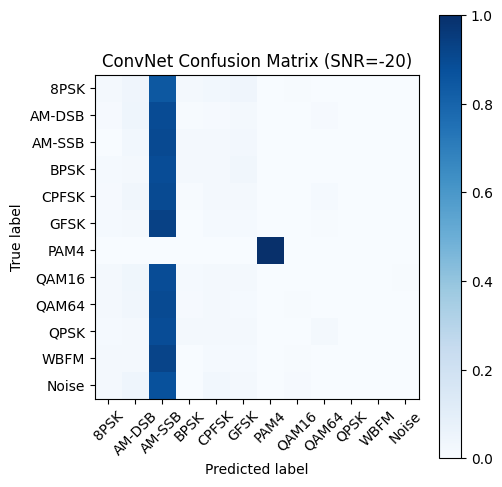

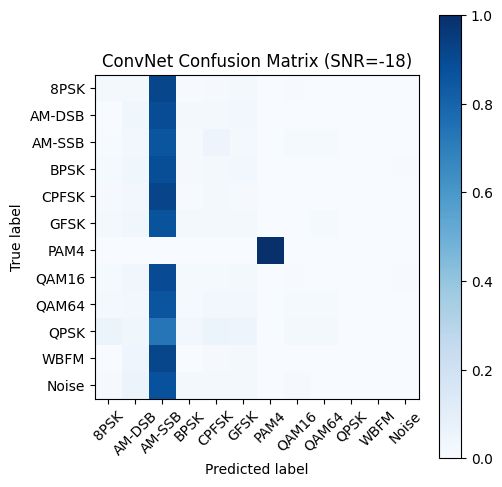

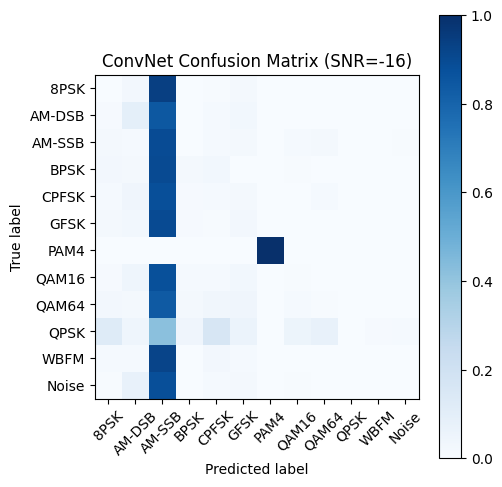

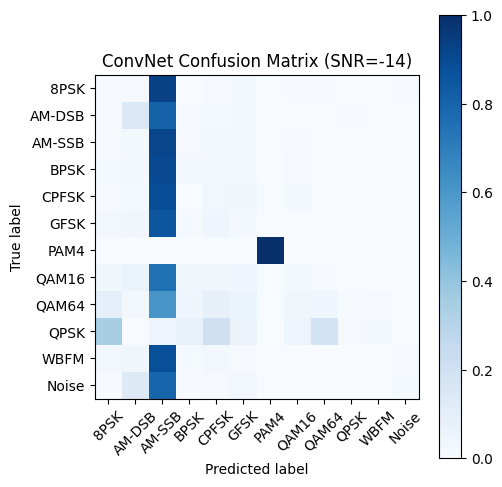

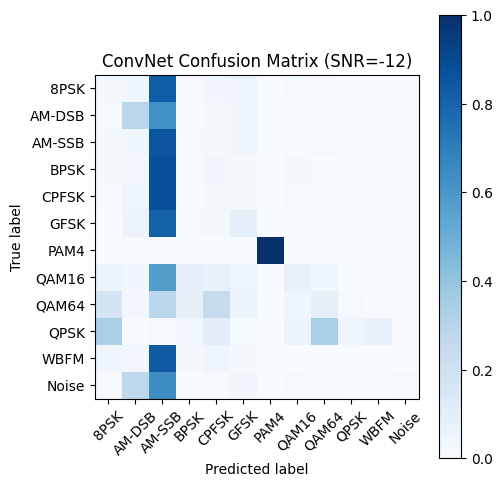

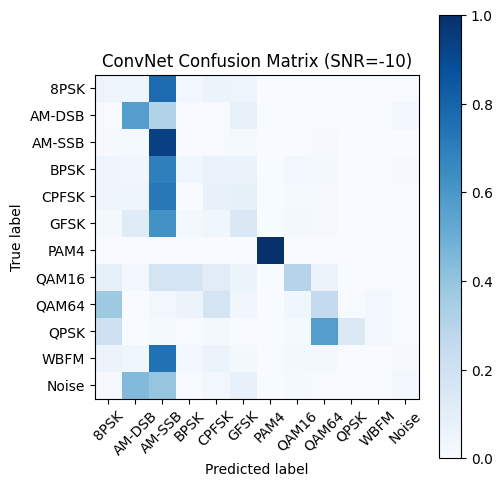

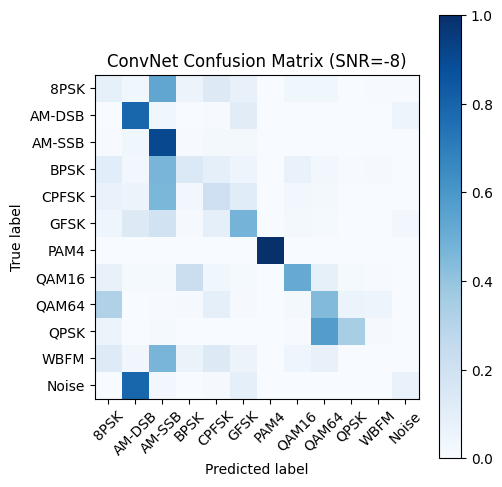

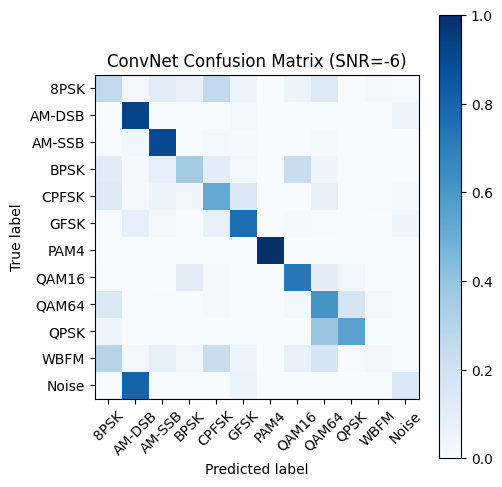

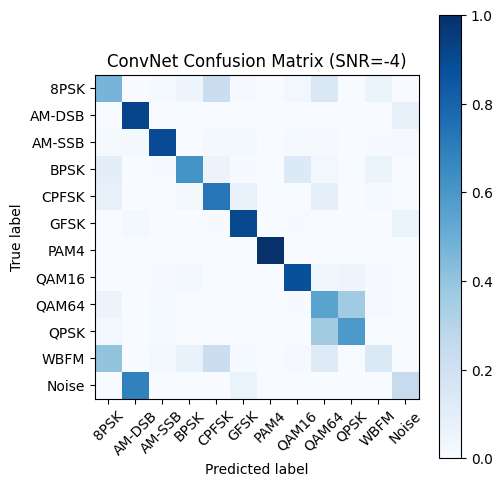

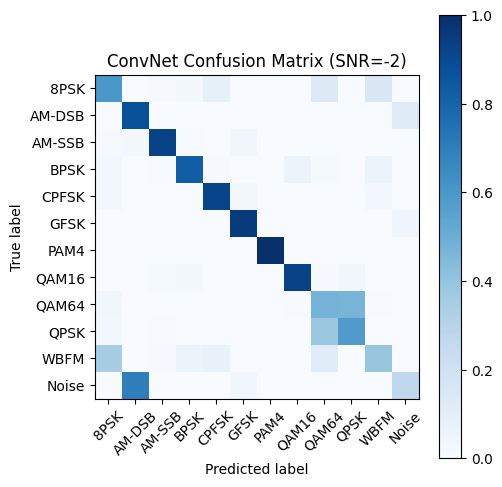

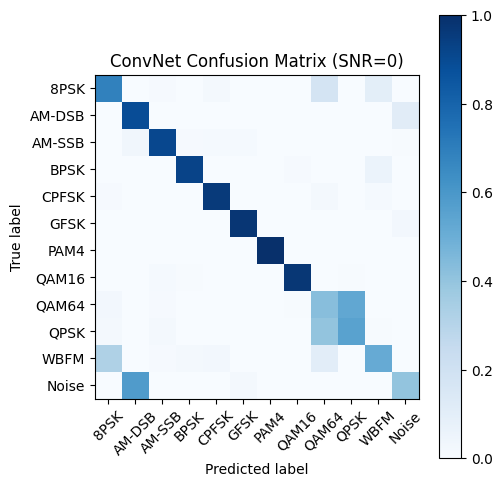

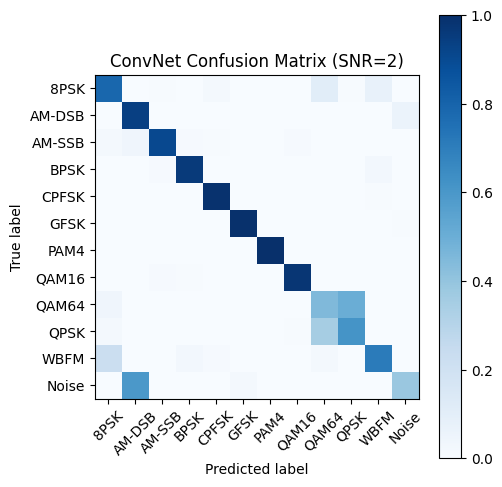

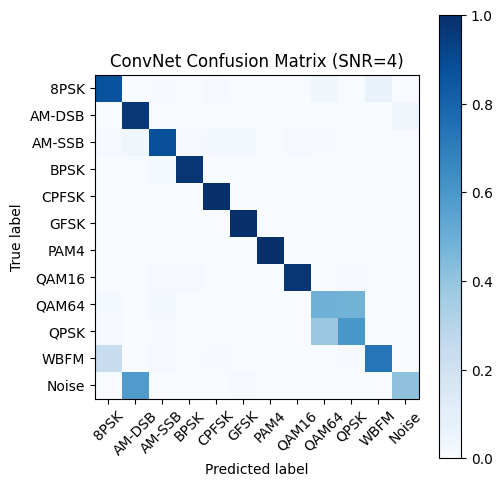

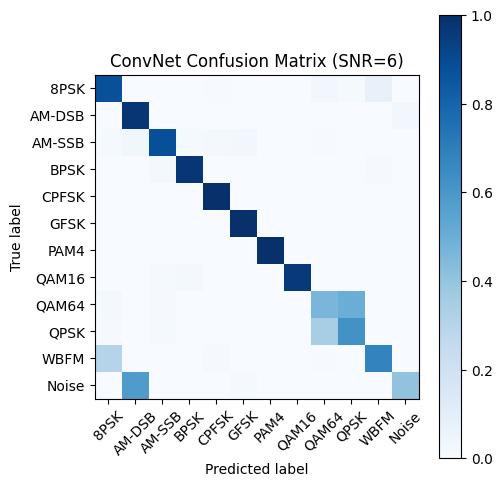

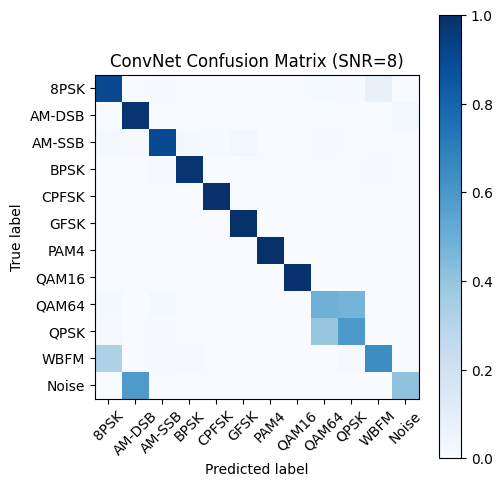

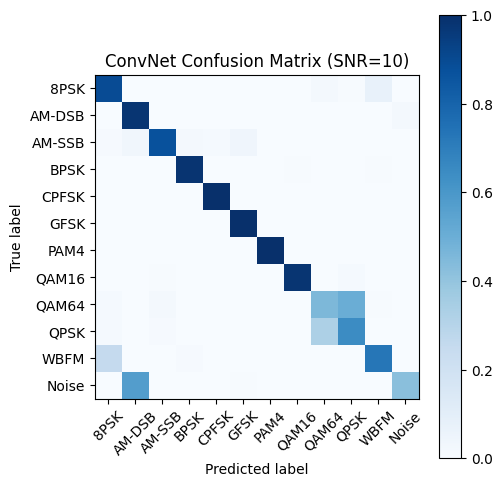

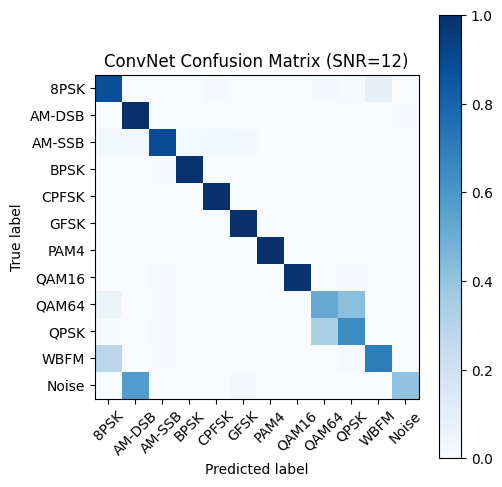

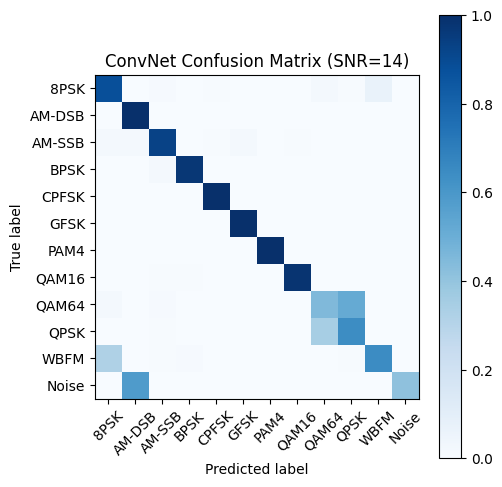

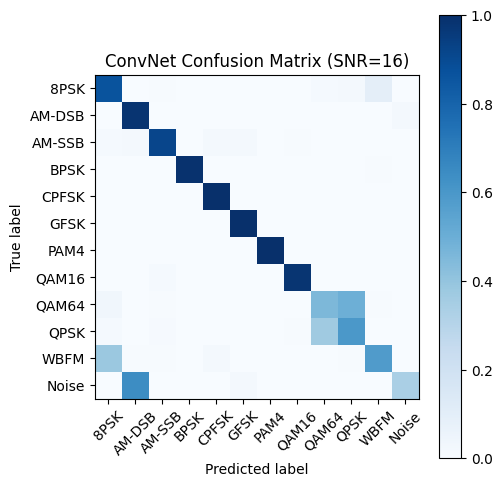

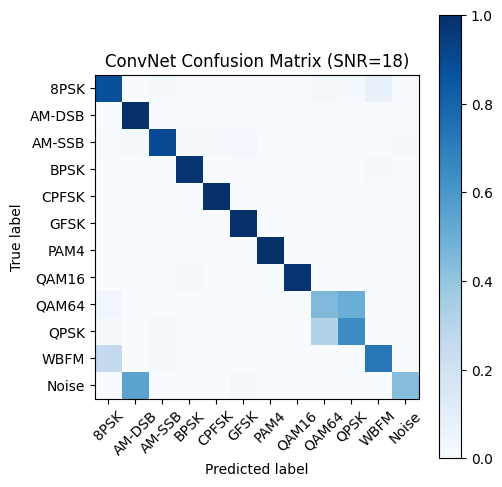

In [23]:
# Plot confusion matrix
acc = {}
for snr in snrs:

    # extract classes @ SNR
    test_SNRs = map(lambda x: int(lbl[x][1]), test_idx)
    test_S = []
    for i in test_SNRs:
      test_S.append(i)
    test_S = np.array(test_S)
    test_X_i = X_test[np.where(test_S == snr)]
    test_Y_i = Y_test[np.where(test_S == snr)]

    # estimate classes
    test_Y_i_hat = model.predict(test_X_i)
    conf = np.zeros([len(classes),len(classes)])
    confnorm = np.zeros([len(classes),len(classes)])
    for i in range(0,test_X_i.shape[0]):
        j = list(test_Y_i[i,:]).index(1)
        k = int(np.argmax(test_Y_i_hat[i,:]))
        conf[j,k] = conf[j,k] + 1
    for i in range(0,len(classes)):
        confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
    plt.figure(figsize=(5,5))
    plot_confusion_matrix(confnorm, labels=classes, title="ConvNet Confusion Matrix (SNR=%d)"%(snr))

    cor = np.sum(np.diag(conf))
    ncor = np.sum(conf) - cor
    print("Overall Accuracy for SNR {}: {}".format(snr, cor / (cor+ncor)))
    acc[snr] = 1.0*cor/(cor+ncor)

En las gráficas anteriores se realiza la matriz de confusión y se extrae la métrica de precisión para las modulaciones teniendo en cuenta todas las SNRs.

Para las SNRs muy pequeñas (negativas), las predicciones son muy imprecisas ya que presentan un nivel de ruido muy alto. Mientras que, para SNRs altas (positivas), las predicciones mejoran considerablemente debido a que la presencia de ruido disminuye.

<h3>Curva de precisión<h3>

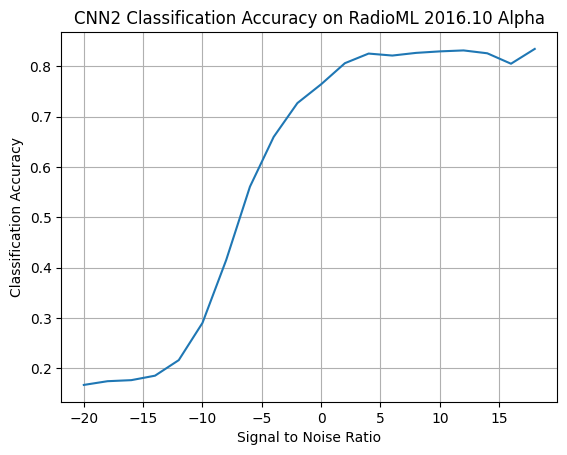

In [24]:
# Plot accuracy curve
a =  map(lambda x: acc[x], snrs)
aux = []
for i in a:
  aux.append(i)

plt.plot(snrs, aux);
plt.xlabel("Signal to Noise Ratio");
plt.ylabel("Classification Accuracy");
plt.title("CNN2 Classification Accuracy on RadioML 2016.10 Alpha");
plt.grid()

Esta curva permite visualizar el comportamiento de la precisión respecto a cada una de las veinte SNRs existentes en el dataset. De lo mencionado anteriormente, se confirma que el accuracy mejora a medida que el valor de SNR incrementa.

## Conclusiones